In [ ]:
# Libraries:
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import Lasso

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # include parent directory in the path
from data import SINDy_data
from data import data
from data import equations

sys.path.append("/home/mattg/D_CODE") # A questo punto è necessario per non doverlo chiamare i file che usano D_CODE.
from D_CODE.run_simulation import run as run_SRT
from D_CODE.run_simulation_vi import run as run_DCODE

from toolbox.auxiliary_functions import SRT_simulation, D_CODE_simulation, set_param_freq, intercept_library_fun, bb_combinations

# Seed:
np.random.seed(999)

/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


# Gompertz ODE

### Gompertz ODE - $a,b$ fixed

In [2]:
# Select ODE & settings:

ode_name = 'GompertzODE' # help="name of the ode", type=str
ode_param = '1.5,1.5' # help="parameters of the ode (default: None)", type=str, default=None
x_id = 0 # help="ID of the equation to be learned", type=int, default=0
freq = 10 # help="sampling frequency", type=float, default=10
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_sigma = 0.01 # help="noise level (default 0)", type=float, default=0.
seed = 100 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10

ode_param, freq = set_param_freq(ode_param, freq)

ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 1
dim_k = 0
time_vector = np.arange(0, ode.T + dt, dt)
T = ode.T

(50, 160, 1) (50, 160, 1) (0,)
['X0']


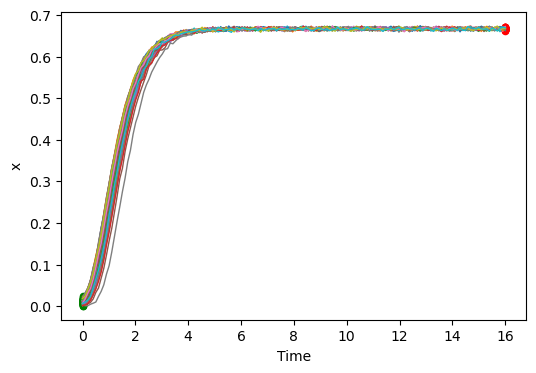

In [3]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_sigma, dim_x, dim_k)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

# ensure existance conditions:
X_list = SINDy_data.existence_conditions(X_list, ode.init_low, n_variables=dim_x)

SINDy_data.plot_configuration(X_list, T)

In [4]:
# additional building blocks -> running D-CODE:
building_blocks_lambda, function_names = D_CODE_simulation(ode_name, ode_param, x_id, freq, n_sample, noise_sigma, seed=seed, n_seed=n_seed, T=T)
None

Running with: ode_name=GompertzODE, ode_param=[1.5, 1.5], x_id=0, freq=10, n_sample=50, noise_sigma=0.01, seed=100, n_seed=1
Dataset shape before smoothing:  (161, 50, 1)
Dataset shape:  (321, 50, 1)
Functions set:  {'neg': 1, 'mul': 1, 'log': 1, 'add': 1, 'sub': 1, 'div': 1, 'pow': 1, 'sin': 1, 'cos': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.67      4.65757e+13       12         0.239017         0.575334      1.71m
   1    10.25      1.14912e+09       12         0.263296         0.356819      1.14m
   2     9.04      2.16866e+09       10        0.0505157         0.046946     46.76s
 
promising programs:
mul(sin(X0), sub(neg(log(X0)), mul(X0, X0)))
mul(sin(pow(X0, 1.526)), mul(sub(sub(div(1.040, X0), add(1.277, X0)), div(pow(X0, pow(X0, 1.064)), neg(1.870))), div(X0, X0)

In [5]:
# fit and evaluate models:

# # upload data:
# file_path = 'saved/data/gompertz_data.pkl'
# with open(file_path, 'rb') as f:
#     X_list, dX_list, param_list, feature_names = dill.load(f)

# # upload building blocks:
# file_path = 'saved/building_blocks/gompertz_bb.pkl'
# with open(file_path, 'rb') as f:
#     building_blocks_lambda, function_names = dill.load(f)

# intercept library:
intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)

errors = []
n_features_vec = []
for i in range(len(building_blocks_lambda)):
    # custom library with building blocks:
    custom_library = ps.CustomLibrary(library_functions=[building_blocks_lambda[i]], function_names=[function_names[i]])
    
    # enlarged library, adding the building block to polynomial library:
    generalized_library = ps.GeneralizedLibrary(
        libraries=[polynomial_library, custom_library],
        tensor_array=[[1, 1]] 
    )

    # add the intercept:
    final_library = ps.ConcatLibrary([intercept_library, generalized_library])

    # fitting the model:
    model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.1))
    model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)

    #library:
    print('')
    print('library:')
    library_terms = final_library.get_feature_names(input_features=feature_names)
    for term in library_terms:
        print(term)

    # final model:
    print('')
    print('model:')
    model.print()

    # evaluate the model:
    
    # filter too complex models (for sure not correct and likely to crash the code):
    coefficients = model.coefficients()
    lasso_penalty = np.sum(np.abs(coefficients))
    if np.count_nonzero(np.array(model.coefficients())) < 5 and lasso_penalty < 5:

        # enlarging initial range to test model robustness:
        # l = (ode.init_high - ode.init_low)/2 # print(l)
        # init_low = max(ode.init_low - l, 0)
        # init_high = ode.init_high + l #print(init_low, init_high)

        # compute MSE:
        _, mse = SINDy_data.evaluate_RMSE(model, ode, freq, 25, ode.init_high, ode.init_low, dim_k)

        # final evaluation metric:
        alpha = 0.01 # regularization parameter
        error = mse + alpha * lasso_penalty
        print('error:', error)
    else:
        error = 1000
        print('')
        print('Too complex model')
    
    errors.append(error)
    n_features_vec.append(np.count_nonzero(np.array(model.coefficients())))
    print('')
    

print('errors:', errors)


library:
1
X0
X0^2
log(X0)
X0 log(X0)
X0^2 log(X0)

model:
(X0)' = -0.714 X0^2 + -1.171 X0 log(X0)
error: 0.01894705504688732


library:
1
X0
X0^2
X0**(X0**1.0639565409660494)
X0 X0**(X0**1.0639565409660494)
X0^2 X0**(X0**1.0639565409660494)

model:
(X0)' = 2.080 1 + 1.928 X0 + -3.331 X0^2 + -2.045 X0**(X0**1.0639565409660494) + -4.031 X0 X0**(X0**1.0639565409660494) + 5.133 X0^2 X0**(X0**1.0639565409660494)

Too complex model


library:
1
X0
X0^2
X0**1.0639565409660494
X0 X0**1.0639565409660494
X0^2 X0**1.0639565409660494

model:
(X0)' = 0.031 1 + 28.393 X0 + 81.119 X0^2 + -31.205 X0**1.0639565409660494 + -83.214 X0 X0**1.0639565409660494 + 4.489 X0^2 X0**1.0639565409660494

Too complex model


library:
1
X0
X0^2
cos(X0 - cos(X0))
X0 cos(X0 - cos(X0))
X0^2 cos(X0 - cos(X0))

model:
(X0)' = 4.150 X0 + -7.147 X0^2 + 0.124 cos(X0 - cos(X0)) + -2.935 X0 cos(X0 - cos(X0)) + 5.052 X0^2 cos(X0 - cos(X0))

Too complex model


library:
1
X0
X0^2
log(1.4774099379841534*X0)
X0 log(1.47740993798

In [9]:
# Final model:
# there are many models with similar error -> we choose the simplest model (less features):

min_error = min(errors)
idxs = [i for i, e in enumerate(errors) if abs(e - min_error) < 0.1]
n_features_vec_2 = [n_features_vec[i] for i in idxs]

if len(idxs) > 1:
    print('Multiple models with similar error, choosing the simplest one')
    print('')
    idx = idxs[np.argmin(n_features_vec_2)]
else:
    idx = idxs[0]

# intercept library:
intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)

# custom library with building blocks:
custom_library = ps.CustomLibrary(library_functions=[building_blocks_lambda[idx]], function_names=[function_names[idx]])
model = ps.SINDy(feature_names=feature_names, feature_library=custom_library, optimizer=ps.STLSQ(threshold=0.01))
model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)
building_block = custom_library.get_feature_names(input_features=feature_names)

# enlarged library, adding building blocks to polynomial library:
generalized_library = ps.GeneralizedLibrary(
    libraries=[polynomial_library, custom_library],
    tensor_array=[[1, 1]] 
)

# add the intercept:
final_library = ps.ConcatLibrary([intercept_library, generalized_library])

# fitting the model:
model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.1))
model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)


# best builging block:
print('Best building block:')
print(building_block)
print('')

# final model:
print('Smart-SINDy model:')
model.print()

Multiple models with similar error, choosing the simplest one

Best building block:
['log(1.4774099379841534*X0)']

Smart-SINDy model:
(X0)' = -1.422 X0 log(1.4774099379841534*X0)


Best Model RMSE:  0.010226203928320772


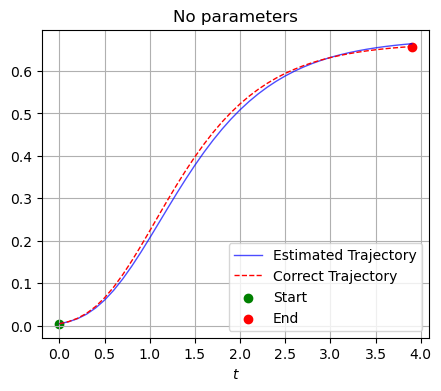

In [7]:
# evaluation
n_sample = 25
rmse_sigma, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, ode.init_high, ode.init_low, dim_k)
print('Best Model RMSE: ', rmse_sigma)

n_sample = 1
title = r'No parameters'
SINDy_data.evaluate_traj(model, ode, freq, n_sample, [0.005], [0.005], dim_x, dim_k, title=title, T_aux=4)

### Gompertz ODE - $a,b$ varying

In [6]:
# Select ODE & settings:

ode_name = 'GompertzODE_par_ab' # help="name of the ode", type=str
ode_param = None # help="parameters of the ode (default: None)", type=str, default=None
x_id = 0 # help="ID of the equation to be learned", type=int, default=0
freq = 10 # help="sampling frequency", type=float, default=10
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_sigma = 0.01 # help="noise level (default 0)", type=float, default=0.
seed = 100 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10

ode_param, freq = set_param_freq(ode_param, freq)

ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 1
dim_k = 2
time_vector = np.arange(0, ode.T + dt, dt)
T = ode.T

(50, 80, 1) (50, 80, 1) (50, 80, 2)
['X0', 'X1', 'X2']


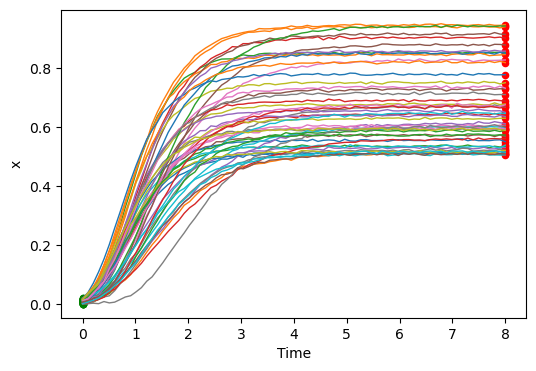

In [7]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_sigma, dim_x, dim_k)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

# ensure existance conditions:
X_list = SINDy_data.existence_conditions(X_list, ode.init_low, n_variables=dim_x)

SINDy_data.plot_configuration(X_list, T)

In [8]:
# additional building blocks -> running D-CODE:
building_blocks_lambda, function_names = D_CODE_simulation(ode_name, ode_param, x_id, freq, n_sample, noise_sigma, seed=seed, n_seed=n_seed, T=T)
None

Running with: ode_name=GompertzODE_par_ab, ode_param=None, x_id=0, freq=10, n_sample=50, noise_sigma=0.01, seed=100, n_seed=1
Dataset shape:  (161, 50, 3)
Functions set:  {'neg': 1, 'mul': 1, 'log': 1, 'add': 1, 'sub': 1, 'div': 1, 'pow': 1, 'sin': 1, 'cos': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.12      2.10879e+15       20         0.669259         0.320378      1.83m
   1     8.36      1.18731e+12       20        0.0894258         0.223839      1.79m
   2     5.55      3.67188e+06       17        0.0163617        0.0320014      1.69m
 
promising programs:
mul(X1, mul(log(mul(X2, X0)), neg(X0)))
mul(div(add(X1, X1), neg(add(X0, X0))), mul(log(mul(X2, X0)), pow(X0, 1.971)))
mul(div(add(X1, X1), neg(add(X0, X0))), mul(log(mul(X2, X0)), pow(X0, 1.971)))
mul(div(add(X1, 

In [9]:
# fit and evaluate models:

# # upload data:
# file_path = 'saved/data/gompertz_data.pkl'
# with open(file_path, 'rb') as f:
#     X_list, dX_list, param_list, feature_names = dill.load(f)

# # upload building blocks:
# file_path = 'saved/building_blocks/gompertz_bb.pkl'
# with open(file_path, 'rb') as f:
#     building_blocks_lambda, function_names = dill.load(f)

# intercept library:
intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)

errors = []
n_features_vec = []
for i in range(len(building_blocks_lambda)):
    # custom library with building blocks:
    custom_library = ps.CustomLibrary(library_functions=[building_blocks_lambda[i]], function_names=[function_names[i]])
    
    # enlarged library, adding the building block to polynomial library:
    generalized_library = ps.GeneralizedLibrary(
        libraries=[polynomial_library, custom_library],
        tensor_array=[[1, 1]] 
    )

    # add the intercept:
    final_library = ps.ConcatLibrary([intercept_library, generalized_library])

    # fitting the model:
    model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.1))
    model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)

    #library:
    print('')
    print('library:')
    library_terms = final_library.get_feature_names(input_features=feature_names)
    for term in library_terms:
        print(term)

    # final model:
    print('')
    print('model:')
    model.print()

    # evaluate the model:
    
    # filter too complex models (for sure not correct and likely to crash the code):
    coefficients = model.coefficients()
    lasso_penalty = np.sum(np.abs(coefficients))
    if np.count_nonzero(np.array(model.coefficients())) < 5 and lasso_penalty < 5:

        # enlarging initial range to test model robustness:
        # l = (ode.init_high - ode.init_low)/2 # print(l)
        # init_low = max(ode.init_low - l, 0)
        # init_high = ode.init_high + l #print(init_low, init_high)

        # compute MSE:
        _, mse = SINDy_data.evaluate_RMSE(model, ode, freq, 25, ode.init_high, ode.init_low, dim_k)

        # final evaluation metric:
        alpha = 0.01 # regularization parameter
        error = mse + alpha * lasso_penalty
        print('error:', error)
    else:
        error = 1000
        print('')
        print('Too complex model')
    
    errors.append(error)
    n_features_vec.append(np.count_nonzero(np.array(model.coefficients())))
    print('')
    

print('errors:', errors)


library:
1
X0
X1
X2
X0^2
X0 X1
X0 X2
X1^2
X1 X2
X2^2
log(X0*X2)
X0 log(X0*X2)
X1 log(X0*X2)
X2 log(X0*X2)
X0^2 log(X0*X2)
X0 X1 log(X0*X2)
X0 X2 log(X0*X2)
X1^2 log(X0*X2)
X1 X2 log(X0*X2)
X2^2 log(X0*X2)

model:
(X0)' = -1.000 X0 X1 log(X0*X2)
error: 0.00999775489165897


library:
1
X0
X1
X2
X0^2
X0 X1
X0 X2
X1^2
X1 X2
X2^2
X0**1.9709380822878872
X0 X0**1.9709380822878872
X1 X0**1.9709380822878872
X2 X0**1.9709380822878872
X0^2 X0**1.9709380822878872
X0 X1 X0**1.9709380822878872
X0 X2 X0**1.9709380822878872
X1^2 X0**1.9709380822878872
X1 X2 X0**1.9709380822878872
X2^2 X0**1.9709380822878872

model:
(X0)' = 4.714 X0 + 261.232 X0^2 + 1.650 X0 X1 + -1.442 X0 X2 + -263.929 X0**1.9709380822878872 + -1.019 X1 X0**1.9709380822878872 + 2.287 X2 X0**1.9709380822878872 + -1.717 X0^2 X0**1.9709380822878872 + 0.690 X0 X1 X0**1.9709380822878872 + -1.695 X0 X2 X0**1.9709380822878872 + -1.275 X1 X2 X0**1.9709380822878872 + 0.464 X2^2 X0**1.9709380822878872

Too complex model


library:
1
X0
X1
X2
X

In [19]:
# Final model:
# there are many models with similar error -> we choose the simplest model (less features):

min_error = min(errors)
idxs = [i for i, e in enumerate(errors) if abs(e - min_error) < 0.1]
n_features_vec_2 = [n_features_vec[i] for i in idxs]

if len(idxs) > 1:
    print('Multiple models with similar error, choosing the simplest one')
    print('')
    idx = idxs[np.argmin(n_features_vec_2)]
else:
    idx = idxs[0]

# intercept library:
intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)

# custom library with building blocks:
custom_library = ps.CustomLibrary(library_functions=[building_blocks_lambda[idx]], function_names=[function_names[idx]])
model = ps.SINDy(feature_names=feature_names, feature_library=custom_library, optimizer=ps.STLSQ(threshold=0.01))
model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
building_block = custom_library.get_feature_names(input_features=feature_names)

# enlarged library, adding building blocks to polynomial library:
generalized_library = ps.GeneralizedLibrary(
    libraries=[polynomial_library, custom_library],
    tensor_array=[[1, 1]] 
)

# add the intercept:
final_library = ps.ConcatLibrary([intercept_library, generalized_library])

# fitting the model:
model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.1))
model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)


# best builging block:
print('Best building block:')
print(building_block)
print('')

# final model:
print('Smart-SINDy model:')
model.print()

Best building block:
['log(X0*X2)']

Smart-SINDy model:
(X0)' = -1.000 X0 X1 log(X0*X2)


Best Model RMSE:  4.6235755258028955e-05


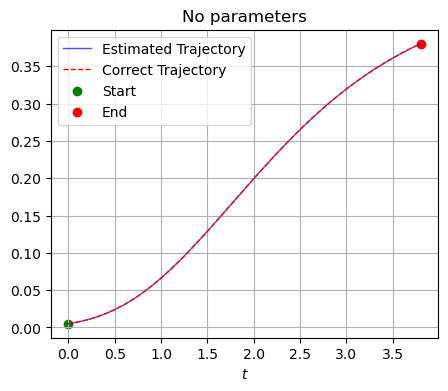

In [20]:
# evaluation
n_sample = 25
rmse_sigma, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, ode.init_high, ode.init_low, dim_k)
print('Best Model RMSE: ', rmse_sigma)

n_sample = 1
title = r'No parameters'
SINDy_data.evaluate_traj(model, ode, freq, n_sample, [0.005, 0.85, 2.2], [0.005, 0.85, 2.2], dim_x, dim_k, title=title, T_aux=4)

In questa implementazione, gira tutto perfettamente: fai girare un metodo di Symbolic Regression, estrai un building block alla volta e fitti SINDy. Semplice ma efficacie.